In [4]:
#Define functions (Always run)

import pandas as pd
import numpy as np
from os import listdir

#Import the data from the file
def read_data(filename):
    #Open file and read all first 11 lines
    data = open(filename)
    text = ''
    params = {}

    params1 = ['metric','fType']
    for i in range(2):
        row   = data.readline()
        text += row
        params.update({params1[i]:row.split(':')[1][1:-1]})
    params2 = ['p0','r0','d','Kreiss-Oliger','deltaR']
    for i in range(5):
        row   = data.readline()
        text += row
        params.update({params2[i]:float(row.split(':')[1])})
    params3 = ['maxR','iterations','nP','time']
    for i in range(4):
        row   = data.readline()
        text += row
        params.update({params3[i]:int(row.split(':')[1])})
    params.update({'text':text})
    #Read data for R, phi, Phi and Pi
    rdata = list(map(float,(data.readline().split(','))[:-1]))
    alldata = data.readlines()
    data.close()
    len_5 = int(len(alldata)/5)
    if(len_5*5 !=len(alldata)):
        raise ValueError

    for i in range(5*len_5):
        alldata[i] = list(map(float,(alldata[i].replace('-nan(ind)','nan').split(','))[:-1]))
    fdata = np.array(alldata[:len_5])
    xdata = np.array(alldata[len_5:2*len_5])
    ydata = np.array(alldata[2*len_5:3*len_5])
    if(params['metric'].startswith('Modified Choptuik')):
        grdata = (np.array(alldata[3*len_5:4*len_5]))**2
        g0data = (np.array(alldata[4*len_5:]))**2
    else:
        grdata = (np.array(alldata[3*len_5:4*len_5]))**(-2)
        g0data = (np.array(alldata[4*len_5:]))**(-2)

    return rdata, fdata, xdata, ydata, grdata, g0data, params

def read_binaries(binData='Data.bin',binX='X.bin',binY='Y.bin',metaData='Meta.dat'):
    params = {'text':'text pending'}
    with open(binData,'rb') as file:
        hdata = np.fromfile(file, dtype=np.float32)
    with open(binX,'rb') as file:
        xdata = np.fromfile(file, dtype=np.float32)
    with open(binY,'rb') as file:
        ydata = np.fromfile(file, dtype=np.float32)
    iterations = int(len(hdata)/(len(xdata)*len(ydata)))
    Nx = int(len(xdata))
    Ny = int(len(ydata))
    hdata = hdata.reshape((iterations,Ny,Nx))
    return  xdata, ydata, hdata, params
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


#Animation in paralel of scalar fields
def animate_data(filename, ipf = 1,output_name = None,ls='-',marker='',ms=0.5):
    x,y,f,params = read_binaries()
    Nx = int(len(x))
    Ny = int(len(y))

    IPF = ipf #Iterations per frame
    iterations = len(f)
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    X, Y = np.meshgrid(x, y)
    #R = np.sqrt(X**2 + Y**2)
    Z = f[0]

    # Plot the 3D surface
    #ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
    
    # Make data.

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, linewidth=0.5, antialiased=False)

    #Create a function that changes the data every frame
    def animate(i,surf):
        it = i*IPF
        surf.remove()
        surf = ax.plot_surface(X, Y, f[it], linewidth=0.5, antialiased=False)
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES, fargs=(surf),
                                    interval=100, repeat_delay=3000)
    if (output_name == None):
        output_name = filename[:-3]+'gif'
    anim.save(output_name,writer='pillow')
    plt.close()


def plot_last(filename, diff_from_collapse=-1, replace_nan=-1):
    r,f,x,y,gr,g0,params = read_data(filename)


    iterations = len(f)

    #Find the last iteration before collapse
    last_iteration = iterations-1
    for i in range(iterations):
        f_nan  = np.any(np.isnan( f[i]))
        #f_nan  = False
        x_nan  = np.any(np.isnan( x[i]))
        y_nan  = np.any(np.isnan( y[i]))
        gr_nan = np.any(np.isnan(gr[i]))
        g0_nan = np.any(np.isnan(g0[i]))
        if np.any((f_nan,x_nan,y_nan,gr_nan,g0_nan)):
            last_iteration = i+diff_from_collapse
            break

    fig, ax = plt.subplots(3,2,figsize=(12,12),dpi=100)

    ax[0,0].plot(r,np.nan_to_num( f[last_iteration],nan=replace_nan))[0]
    ax[1,0].plot(r,np.nan_to_num( x[last_iteration],nan=replace_nan))[0]
    ax[2,0].plot(r,np.nan_to_num( y[last_iteration],nan=replace_nan))[0]
    ax[1,1].plot(r,np.nan_to_num(gr[last_iteration],nan=replace_nan))[0]
    ax[2,1].plot(r,np.nan_to_num(g0[last_iteration],nan=replace_nan))[0]
    ax[0,0].text(1.21,0.98,params['text']+f'\nPrinted iteration: {last_iteration}',verticalalignment='top',transform=ax[0,0].transAxes)
    ax[0,1].remove()
    #ax[1,1].set_ylim(-0.1,1.1)
    #ax[2,1].set_ylim(-0.1,1.1)
    ax[0,0].set_title('$\phi$')
    ax[1,0].set_title('$\Phi$')
    ax[2,0].set_title('$\Pi$')
    ax[1,1].set_title('$g^{rr}$')
    ax[2,1].set_title('$g^{00}$')

    plt.show()

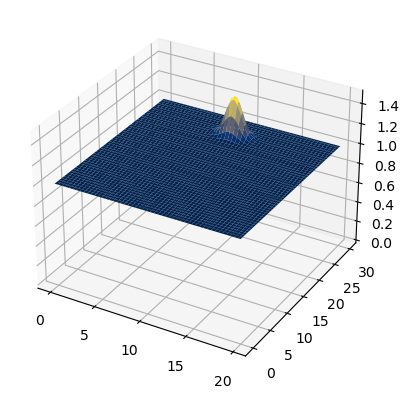

In [7]:
#animate_data('File.dat')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation

x,y,f,params = read_binaries()
Nx = int(len(x))
Ny = int(len(y))

IPF = 10 #Iterations per frame

def update_plot(frame_number, zarray, plot):
    frame = frame_number*IPF
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, Zarray[frame],color='0.75',cmap='cividis')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)
Zarray = f

plot = [ax.plot_surface(X, Y, Zarray[0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,1.5)
animate = animation.FuncAnimation(fig, update_plot, int(len(f)/IPF), fargs=(Zarray, plot))
animate.save('shallow_waters.gif',writer='pillow')